In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import numpy as np
from numpy.random import seed
seed(1)
tf.random.set_seed(1)
random.seed(1)

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn, 
        distillation_loss_fn,
        alpha,
        temperature,
    ):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data
        teacher_predictions = self.teacher(x, training=False)
   
        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
             )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train = keras.applications.resnet_v2.preprocess_input(x_train)
x_test = keras.applications.resnet_v2.preprocess_input(x_test)

x_train.shape

(50000, 32, 32, 3)

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))

upscale = keras.layers.Lambda(lambda x: tf.image.resize(x, [64, 64]))(inputs)
input_shape = (64, 64, 3)

teacher = keras.applications.ResNet152V2(
    include_top=False,
    input_tensor=upscale,
    input_shape=input_shape,
    pooling='avg',
    weights = 'imagenet'
)

teacher.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
teacher_trained = teacher.fit(x_train, y_train, epochs = 10, batch_size = 128)
teacher.evaluate(x_test, y_test)

Epoch 1/10
391/391 [==============================] - 96s 195ms/step - loss: 5.4951 - sparse_categorical_accuracy: 0.4542
Epoch 2/10
391/391 [==============================] - 75s 193ms/step - loss: 3.8357 - sparse_categorical_accuracy: 0.6892
Epoch 3/10
391/391 [==============================] - 75s 191ms/step - loss: 3.0165 - sparse_categorical_accuracy: 0.7523
Epoch 4/10
391/391 [==============================] - 75s 192ms/step - loss: 1.9911 - sparse_categorical_accuracy: 0.8004
Epoch 5/10
391/391 [==============================] - 75s 192ms/step - loss: 1.3298 - sparse_categorical_accuracy: 0.8455
Epoch 6/10
391/391 [==============================] - 75s 193ms/step - loss: 0.9433 - sparse_categorical_accuracy: 0.8803
Epoch 7/10
391/391 [==============================] - 75s 192ms/step - loss: 0.6995 - sparse_categorical_accuracy: 0.9019
Epoch 8/10
391/391 [==============================] - 75s 191ms/step - loss: 0.5265 - sparse_categorical_accuracy: 0.9214
Epoch 9/10
391/391 [====

[1.127295970916748, 0.7965999841690063]

In [ ]:
student = keras.applications.ResNet50V2(
    include_top=False,
    input_tensor=upscale,
    input_shape=input_shape,
    pooling='avg',
    weights = 'imagenet'
)
student_scratch = keras.models.clone_model(student)

distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=2,
)

distilled = distiller.fit(x_train, y_train, epochs=10, batch_size=128)
distiller.evaluate(x_test, y_test)

Epoch 1/10
391/391 [==============================] - 60s 131ms/step - sparse_categorical_accuracy: 0.5048 - student_loss: 3.7975 - distillation_loss: 0.2484
Epoch 2/10
391/391 [==============================] - 52s 133ms/step - sparse_categorical_accuracy: 0.7507 - student_loss: 2.7146 - distillation_loss: 0.1808
Epoch 3/10
391/391 [==============================] - 52s 133ms/step - sparse_categorical_accuracy: 0.7889 - student_loss: 2.1694 - distillation_loss: 0.1469
Epoch 4/10
391/391 [==============================] - 52s 134ms/step - sparse_categorical_accuracy: 0.8263 - student_loss: 1.6840 - distillation_loss: 0.1174
Epoch 5/10
391/391 [==============================] - 52s 133ms/step - sparse_categorical_accuracy: 0.8592 - student_loss: 1.1108 - distillation_loss: 0.0884
Epoch 6/10
391/391 [==============================] - 52s 134ms/step - sparse_categorical_accuracy: 0.8903 - student_loss: 0.7785 - distillation_loss: 0.0690
Epoch 7/10
391/391 [==============================] 

[0.8241000175476074, 0.78266441822052]

In [ ]:
student_scratch.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

student_trained = student_scratch.fit(x_train, y_train, epochs=10, batch_size = 128)
student_scratch.evaluate(x_test, y_test)

Epoch 1/10
391/391 [==============================] - 35s 77ms/step - loss: 6.2109 - sparse_categorical_accuracy: 0.3777
Epoch 2/10
391/391 [==============================] - 30s 77ms/step - loss: 4.2271 - sparse_categorical_accuracy: 0.6216
Epoch 3/10
391/391 [==============================] - 30s 77ms/step - loss: 2.8920 - sparse_categorical_accuracy: 0.7088
Epoch 4/10
391/391 [==============================] - 30s 77ms/step - loss: 1.9104 - sparse_categorical_accuracy: 0.7719
Epoch 5/10
391/391 [==============================] - 30s 77ms/step - loss: 1.2695 - sparse_categorical_accuracy: 0.8209
Epoch 6/10
391/391 [==============================] - 30s 77ms/step - loss: 0.8721 - sparse_categorical_accuracy: 0.8602
Epoch 7/10
391/391 [==============================] - 30s 77ms/step - loss: 0.5837 - sparse_categorical_accuracy: 0.8956
Epoch 8/10
391/391 [==============================] - 29s 74ms/step - loss: 0.4271 - sparse_categorical_accuracy: 0.9182
Epoch 9/10
391/391 [============

[1.1713025569915771, 0.7700999975204468]

# DISTILLATION ON CIFAR100

In [ ]:
(x_train100, y_train100), (x_test100, y_test100) = keras.datasets.cifar100.load_data()
x_train100 = keras.applications.resnet_v2.preprocess_input(x_train100)
x_test100 = keras.applications.resnet_v2.preprocess_input(x_test100)
x_train100.shape

(50000, 32, 32, 3)

In [ ]:
inputs = keras.Input(shape=(32, 32, 3))

upscale = keras.layers.Lambda(lambda x: tf.image.resize(x, [64, 64]))(inputs)
teacher100 = keras.applications.ResNet152V2(
    include_top=False,
    input_tensor=upscale,
    input_shape=input_shape,
    pooling='avg',
    weights = 'imagenet'
)

teacher100.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
teacher_trained100 = teacher100.fit(x_train100, y_train100, epochs = 15, batch_size = 128)
teacher100.evaluate(x_test100, y_test100)

Epoch 1/15
391/391 [==============================] - 93s 193ms/step - loss: 5.9796 - sparse_categorical_accuracy: 0.1696
Epoch 2/15
391/391 [==============================] - 76s 194ms/step - loss: 3.3511 - sparse_categorical_accuracy: 0.4530
Epoch 3/15
391/391 [==============================] - 75s 191ms/step - loss: 2.6326 - sparse_categorical_accuracy: 0.5564
Epoch 4/15
391/391 [==============================] - 76s 193ms/step - loss: 1.9869 - sparse_categorical_accuracy: 0.6490
Epoch 5/15
391/391 [==============================] - 76s 193ms/step - loss: 1.5825 - sparse_categorical_accuracy: 0.7203
Epoch 6/15
391/391 [==============================] - 75s 193ms/step - loss: 1.3067 - sparse_categorical_accuracy: 0.7735
Epoch 7/15
391/391 [==============================] - 75s 192ms/step - loss: 1.1891 - sparse_categorical_accuracy: 0.8036
Epoch 8/15
391/391 [==============================] - 75s 193ms/step - loss: 1.0814 - sparse_categorical_accuracy: 0.8248
Epoch 9/15
391/391 [====

[2.984543561935425, 0.5322999954223633]

In [ ]:
student100 = keras.applications.ResNet50V2(
    include_top=False,
    input_tensor=upscale,
    input_shape=input_shape,
    pooling='avg',
    weights = 'imagenet'
)
student_scratch100 = keras.models.clone_model(student100)

distiller = Distiller(student=student100, teacher=teacher100)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.3,
    temperature=2,
)

distiller_trained100 = distiller.fit(x_train100, y_train100, epochs=15, batch_size=128)

distiller.evaluate(x_test100, y_test100)

Epoch 1/15
391/391 [==============================] - 61s 132ms/step - sparse_categorical_accuracy: 0.1509 - student_loss: 4.8230 - distillation_loss: 1.3018
Epoch 2/15
391/391 [==============================] - 52s 132ms/step - sparse_categorical_accuracy: 0.4471 - student_loss: 3.1129 - distillation_loss: 0.8943
Epoch 3/15
391/391 [==============================] - 52s 132ms/step - sparse_categorical_accuracy: 0.5583 - student_loss: 2.2804 - distillation_loss: 0.6739
Epoch 4/15
391/391 [==============================] - 52s 132ms/step - sparse_categorical_accuracy: 0.6531 - student_loss: 1.7551 - distillation_loss: 0.5373
Epoch 5/15
391/391 [==============================] - 52s 132ms/step - sparse_categorical_accuracy: 0.7235 - student_loss: 1.3221 - distillation_loss: 0.4235
Epoch 6/15
391/391 [==============================] - 52s 132ms/step - sparse_categorical_accuracy: 0.7841 - student_loss: 1.0231 - distillation_loss: 0.3464
Epoch 7/15
391/391 [==============================] 

[0.5454000234603882, 1.7554209232330322]

In [ ]:
student_scratch100.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

student_trained100 = student_scratch100.fit(x_train100, y_train100, epochs=15, batch_size = 128)
student_scratch100.evaluate(x_test100, y_test100)

Epoch 1/15
391/391 [==============================] - 34s 74ms/step - loss: 6.3190 - sparse_categorical_accuracy: 0.1067
Epoch 2/15
391/391 [==============================] - 29s 74ms/step - loss: 4.3098 - sparse_categorical_accuracy: 0.2701
Epoch 3/15
391/391 [==============================] - 29s 74ms/step - loss: 3.3066 - sparse_categorical_accuracy: 0.3642
Epoch 4/15
391/391 [==============================] - 29s 74ms/step - loss: 2.6120 - sparse_categorical_accuracy: 0.4525
Epoch 5/15
391/391 [==============================] - 29s 74ms/step - loss: 2.0510 - sparse_categorical_accuracy: 0.5365
Epoch 6/15
391/391 [==============================] - 29s 74ms/step - loss: 1.5768 - sparse_categorical_accuracy: 0.6172
Epoch 7/15
391/391 [==============================] - 29s 74ms/step - loss: 1.1685 - sparse_categorical_accuracy: 0.7028
Epoch 8/15
391/391 [==============================] - 29s 74ms/step - loss: 0.8409 - sparse_categorical_accuracy: 0.7775
Epoch 9/15
391/391 [============

[3.126997470855713, 0.45899999141693115]

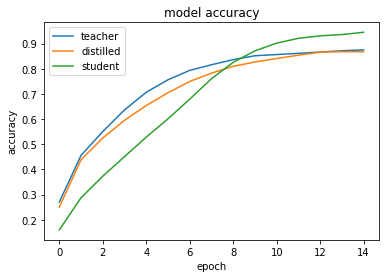

In [ ]:
import matplotlib.pyplot as plt

plt.plot(teacher_trained100.history['sparse_categorical_accuracy'])
plt.plot(distiller_trained100.history['sparse_categorical_accuracy'])
plt.plot(student_trained100.history['sparse_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['teacher', 'distilled', 'student'], loc='upper left')
plt.show()

# INTERMEDIATE DISTILLATION

In [ ]:
class DistillerIntermediate(keras.Model):
    def __init__(self, student, teacher, intermediate_teacher, intermediate_student):
        super(DistillerIntermediate, self).__init__()
        self.teacher = teacher
        self.student = student
        self.intermediate_layer_teacher = intermediate_teacher
        self.intermediate_layer_student = intermediate_student
        
    def compile(
        self,
        optimizer,
        metrics,
        distillation_loss_fn,
        temperature=3,
    ):
        super(DistillerIntermediate, self).compile(optimizer=optimizer, metrics=metrics)
        self.distillation_loss_fn = distillation_loss_fn
        self.temperature = temperature


    def train_step(self, data):
        x, y = data

        intermediate_teacher_predictions = self.intermediate_layer_teacher(x, training=False)

        with tf.GradientTape() as tape:
            intermediate_student_predictions = self.intermediate_layer_student(x, training=False)

            loss = self.distillation_loss_fn(
                (intermediate_teacher_predictions / self.temperature),
                (intermediate_student_predictions / self.temperature),
             )

        trainable_vars = self.intermediate_layer_student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.compiled_metrics.update_state(intermediate_teacher_predictions, intermediate_student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": loss}
        )
        return results

In [ ]:
student = keras.applications.ResNet50V2(
    include_top=False,
    input_tensor=upscale,
    input_shape=input_shape,
    pooling='avg',
    weights = 'imagenet'
)
intermediate_teacher = keras.Model(inputs=teacher.input,
                                   outputs=teacher.get_layer('conv2_block3_out').output)

intermediate_student =  keras.Model(inputs=student.input, 
                                    outputs = student.get_layer('conv2_block3_out').output)

distillerIntermediate = DistillerIntermediate(student=student, 
                                              teacher = teacher,
                                              intermediate_teacher = intermediate_teacher,
                                              intermediate_student = intermediate_student
                                              )

distillerIntermediate.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    distillation_loss_fn=keras.losses.MeanSquaredError(),
    temperature=1,
)

distillerIntermediate.fit(x_train100, y_train100, epochs=10, batch_size=256)

Epoch 1/10
196/196 [==============================] - 11s 50ms/step - accuracy: 0.6569 - student_loss: 3.4381
Epoch 2/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.8747 - student_loss: 0.5838
Epoch 3/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.8920 - student_loss: 0.4035
Epoch 4/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.9080 - student_loss: 0.3299
Epoch 5/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.9203 - student_loss: 0.2833
Epoch 6/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.9283 - student_loss: 0.2517
Epoch 7/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.9339 - student_loss: 0.2323
Epoch 8/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.9374 - student_loss: 0.2123
Epoch 9/10
196/196 [==============================] - 10s 50ms/step - accuracy: 0.9404 - student_loss: 0.1993
Epoch 10/1

In [ ]:
for x in range(40):
  weights = intermediate_student.get_layer(index=x).get_weights()
  student.get_layer(index = x).set_weights(weights)
  student.get_layer(index = x).trainable = False

In [ ]:
intermediate_teacher = keras.Model(inputs=teacher.input,
                                   outputs=teacher.get_layer('conv3_block8_out').output)

intermediate_student =  keras.Model(inputs=student.input, 
                                    outputs = student.get_layer('conv3_block4_out').output)

distillerIntermediate = DistillerIntermediate(student=student, 
                                              teacher = teacher,
                                              intermediate_teacher = intermediate_teacher,
                                              intermediate_student = intermediate_student
                                              )


distillerIntermediate.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    distillation_loss_fn=keras.losses.MeanSquaredError(),
    temperature=1,
)
distillerIntermediate.fit(x_train100, y_train100, epochs=30, batch_size=256)

Epoch 1/30
196/196 [==============================] - 17s 70ms/step - accuracy: 0.1625 - student_loss: 3.5225
Epoch 2/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.4625 - student_loss: 1.4329
Epoch 3/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.5271 - student_loss: 1.1456
Epoch 4/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.5592 - student_loss: 1.0139
Epoch 5/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.5768 - student_loss: 0.9344
Epoch 6/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.5909 - student_loss: 0.8816
Epoch 7/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.6021 - student_loss: 0.8408
Epoch 8/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.6071 - student_loss: 0.8135
Epoch 9/30
196/196 [==============================] - 14s 70ms/step - accuracy: 0.6141 - student_loss: 0.7850
Epoch 10/3

In [ ]:
for x in range(87):
  weights = intermediate_student.get_layer(index=x).get_weights()
  student.get_layer(index = x).set_weights(weights)
  student.get_layer(index = x).trainable = False

In [ ]:
intermediate_teacher = keras.Model(inputs=teacher.input,
                                   outputs=teacher.get_layer('conv4_block36_out').output)

intermediate_student = keras.Model(inputs=student.input, 
                                    outputs = student.get_layer('conv4_block6_out').output)

distillerIntermediate = DistillerIntermediate(student=student, 
                                              teacher = teacher,
                                              intermediate_teacher = intermediate_teacher,
                                              intermediate_student = intermediate_student
                                              )

distillerIntermediate.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
    distillation_loss_fn=keras.losses.MeanSquaredError(),
    temperature=1,
)

distillerIntermediate.fit(x_train100, y_train100, epochs=30, batch_size=256)

Epoch 1/30
196/196 [==============================] - 37s 155ms/step - accuracy: 0.1407 - student_loss: 1.9982
Epoch 2/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.4118 - student_loss: 0.8928
Epoch 3/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.4722 - student_loss: 0.7087
Epoch 4/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.4975 - student_loss: 0.6311
Epoch 5/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.5215 - student_loss: 0.5638
Epoch 6/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.5336 - student_loss: 0.5389
Epoch 7/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.5429 - student_loss: 0.4996
Epoch 8/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.5498 - student_loss: 0.4764
Epoch 9/30
196/196 [==============================] - 30s 155ms/step - accuracy: 0.5612 - student_loss: 0.4564
E

In [ ]:
for x in range(1,155):
  weights = intermediate_student.get_layer(index=x).get_weights()
  student.get_layer(index = x).set_weights(weights)
  student.get_layer(index = x).trainable = False

In [ ]:
student1 = keras.models.clone_model(student)
distiller = Distiller(student=student1, teacher=teacher)
distiller.compile(
    optimizer=keras.optimizers.Adam(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
    student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=2,
)

intermediateHistory = distiller.fit(x_train100, y_train100, epochs=15, batch_size=256)

distiller.evaluate(x_test100, y_test100)

Epoch 1/15
196/196 [==============================] - 39s 156ms/step - sparse_categorical_accuracy: 0.1273 - student_loss: 5.8843 - distillation_loss: 0.2810
Epoch 2/15
196/196 [==============================] - 31s 156ms/step - sparse_categorical_accuracy: 0.2487 - student_loss: 4.7491 - distillation_loss: 0.2640
Epoch 3/15
196/196 [==============================] - 31s 156ms/step - sparse_categorical_accuracy: 0.3129 - student_loss: 4.1053 - distillation_loss: 0.2527
Epoch 4/15
196/196 [==============================] - 31s 156ms/step - sparse_categorical_accuracy: 0.3705 - student_loss: 3.6016 - distillation_loss: 0.2422
Epoch 5/15
196/196 [==============================] - 31s 156ms/step - sparse_categorical_accuracy: 0.4330 - student_loss: 3.1214 - distillation_loss: 0.2312
Epoch 6/15
196/196 [==============================] - 31s 156ms/step - sparse_categorical_accuracy: 0.5128 - student_loss: 2.6547 - distillation_loss: 0.2210
Epoch 7/15
196/196 [==============================] 

[0.2443999946117401, 4.1257429122924805]

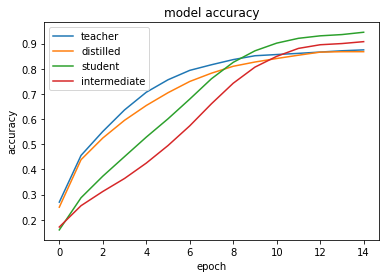

In [ ]:
import matplotlib.pyplot as plt

plt.plot(teacher_trained100.history['sparse_categorical_accuracy'])
plt.plot(distiller_trained100.history['sparse_categorical_accuracy'])
plt.plot(student_trained100.history['sparse_categorical_accuracy'])
plt.plot(intermediateHistory.history['sparse_categorical_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['teacher', 'distilled', 'student', 'intermediate'], loc='upper left')
plt.show()